# Chapter 6.3 – Hidden Units: Activation Functions

Explore the properties and behavior of hidden unit activation functions. This notebook focuses on understanding **what** hidden units do, not on training models.

## Setup
Import necessary libraries for visualization and computation.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
%matplotlib inline

# Workaround for PyTorch ONNX import issue
import warnings
warnings.filterwarnings('ignore')

# Disable torch.compile to avoid _dynamo which triggers ONNX import
import os
os.environ['PYTORCH_JIT'] = '0'
os.environ['TORCH_COMPILE_DISABLE'] = '1'

try:
    import torch
    # Disable compilation features that trigger ONNX
    torch._C._set_graph_executor_optimize(False)
    import torch.nn as nn
    torch.manual_seed(42)
    print("✓ PyTorch imported successfully")
except Exception as e:
    print(f"✗ PyTorch import failed: {e}")
    print("\nTry running in terminal:")
    print("  pip uninstall torch torchvision")
    print("  pip install torch torchvision")

✓ PyTorch imported successfully


## Exercise 1: Visualize Common Activation Functions

Plot the following activation functions and their derivatives:
- ReLU (Rectified Linear Unit)
- Sigmoid
- Tanh (Hyperbolic Tangent)
- Leaky ReLU

Understanding their shapes helps explain their behavior during forward and backward passes.

In [20]:
# TODO: Define activation functions and their derivatives
# Hint: Use numpy functions like np.maximum for ReLU, 1/(1+np.exp(-x)) for sigmoid

def relu(x):
    return np.clip(x, 0, np.inf)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2



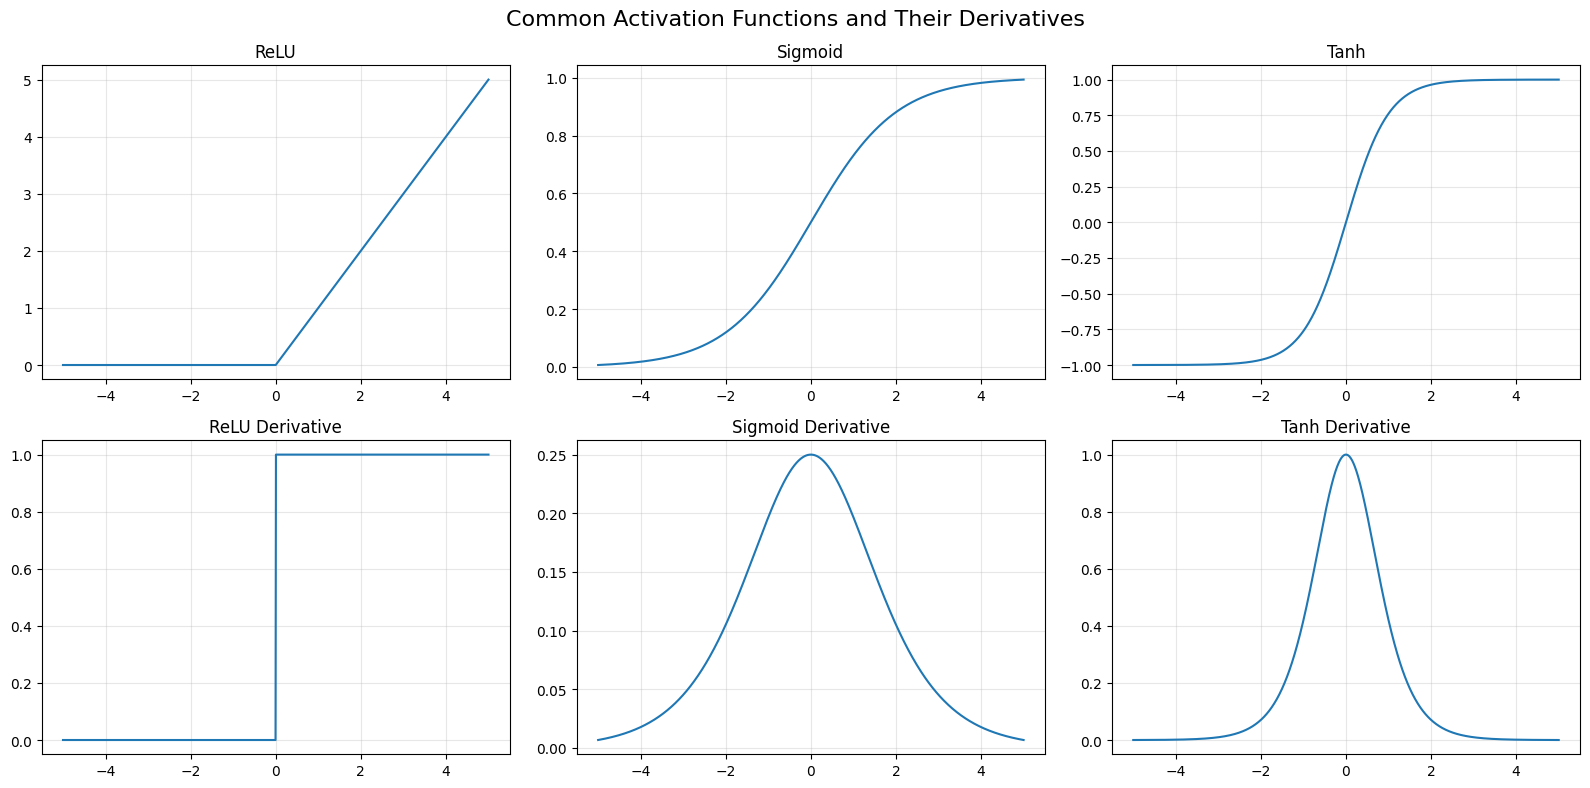

In [21]:
# TODO: Create plots comparing activation functions
# 1. Generate x values from -5 to 5
# 2. Create 2x4 subplot grid (functions on top row, derivatives on bottom)
# 3. Plot each activation and its derivative

x = np.linspace(-5, 5, 1000)

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('Common Activation Functions and Their Derivatives', fontsize=16)

# TODO: Fill in plotting code
# Example structure:
axes[0, 0].plot(x, relu(x))
axes[0, 0].set_title('ReLU')
axes[1, 0].plot(x, relu_derivative(x))
axes[1, 0].set_title('ReLU Derivative')


axes[0, 1].plot(x, sigmoid(x))
axes[0, 1].set_title('Sigmoid')
axes[1, 1].plot(x, sigmoid_derivative(x))
axes[1, 1].set_title('Sigmoid Derivative')


axes[0, 2].plot(x, tanh(x))
axes[0, 2].set_title('Tanh')
axes[1, 2].plot(x, tanh_derivative(x))
axes[1, 2].set_title('Tanh Derivative')







plt.tight_layout()
plt.show()

## Exercise 2: Dead ReLU Problem

Investigate when ReLU units "die" (always output 0). This happens when inputs are consistently negative.

In [22]:
# TODO: Create a simple scenario showing dead ReLU
# 1. Generate random input data
# 2. Create a linear layer with large negative bias
# 3. Apply ReLU activation
# 4. Show input vs output in a table

# Generate input data
x = torch.randn(1000, 10)  # 1000 samples, 10 features
linear = nn.Linear(10, 5)   # 5 hidden units

# Manually set bias to large negative values to "kill" neurons
with torch.no_grad():
    linear.bias.fill_(-10.0)

# Forward pass
pre_activation = linear(x)
post_activation = torch.relu(pre_activation)

# Calculate statistics
dead_percentage = (post_activation == 0).float().mean() * 100
print(f"Percentage of dead neurons: {dead_percentage:.2f}%\n")

# TODO: Display a table showing ReLU input vs output for first 10 samples
print("ReLU Input vs Output (first 10 samples, neuron 0):")
print("-" * 50)
print(f"{'Sample':<10} {'Pre-Activation (Input)':<25} {'Post-Activation (Output)':<25}")
print("-" * 50)

for i in range(10):
    pre_val = pre_activation[i, 0].item()
    post_val = post_activation[i, 0].item()
    print(f"{i:<10} {pre_val:<25.4f} {post_val:<25.4f}")

print("\nObservation: All negative inputs become 0 after ReLU → Dead neuron!")

Percentage of dead neurons: 100.00%

ReLU Input vs Output (first 10 samples, neuron 0):
--------------------------------------------------
Sample     Pre-Activation (Input)    Post-Activation (Output) 
--------------------------------------------------
0          -9.7837                   0.0000                   
1          -10.0322                  0.0000                   
2          -10.4466                  0.0000                   
3          -10.3243                  0.0000                   
4          -10.5448                  0.0000                   
5          -9.7712                   0.0000                   
6          -10.8104                  0.0000                   
7          -11.3418                  0.0000                   
8          -9.8559                   0.0000                   
9          -8.6873                   0.0000                   

Observation: All negative inputs become 0 after ReLU → Dead neuron!


## Exercise 3: Compare Activation Functions on Simple Regression Task

Train three simple networks with different activation functions (ReLU, Sigmoid, Tanh) on the same task. Compare their learning curves to see which activation function learns faster.

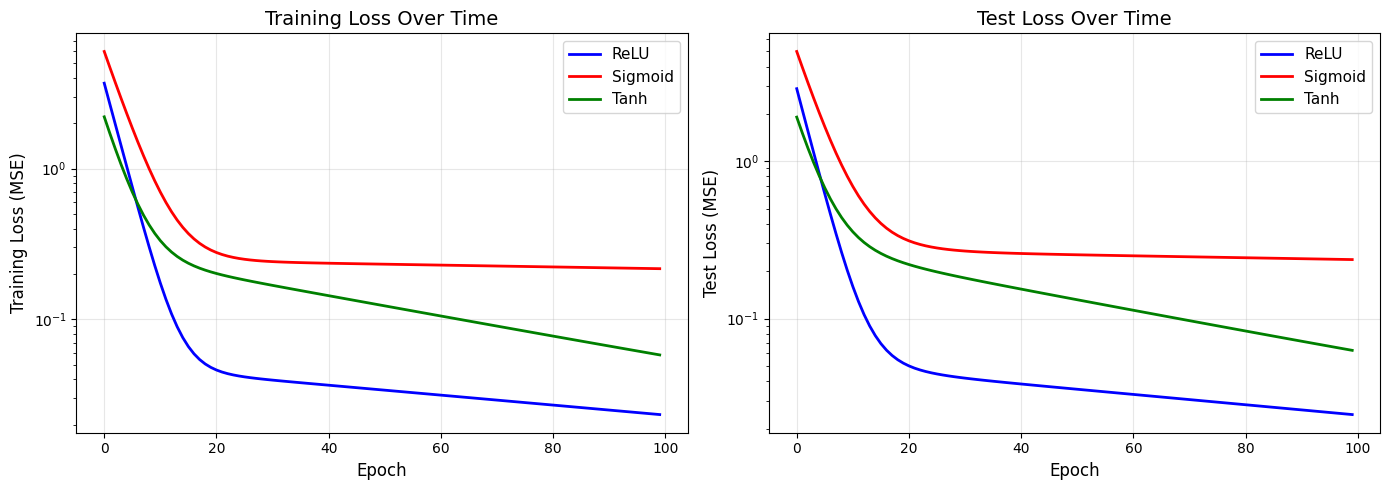


Final Metrics after 100 epochs:
------------------------------------------------------------
Activation      Train Loss      Test Loss      
------------------------------------------------------------
ReLU            0.023322        0.024534       
Sigmoid         0.216735        0.237098       
Tanh            0.058030        0.062801       

💡 Observation:
   - Which activation learns fastest (reaches low loss first)?
   - Which generalizes best (lowest test loss)?
   - Is there overfitting (train loss << test loss)?


In [23]:
# TODO: Train 3 models with different activation functions and compare performance
# 1. Generate data: random x, y = sin(x) + 1 (shifted to be positive)
# 2. Create 3 identical networks with different activations
# 3. Train for several epochs and track loss and accuracy
# 4. Plot learning curves to compare

# Generate synthetic data (train and test)
np.random.seed(42)
torch.manual_seed(42)

# Training data 
x_train = np.random.rand(200, 1)
y_train = np.sin(x_train) + np.power(x_train, 2)+1

# Test data
x_test = np.random.rand(50, 1)
y_test = np.sin(x_test) + np.power(x_test, 2)+1

# Convert to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.FloatTensor(y_test)

# Define model creation function
def create_regression_model(activation_fn):
    """Create a 2-layer network with specified activation"""
    model = nn.Sequential(
        nn.Linear(1, 20),
        activation_fn,
        nn.Linear(20, 1)
    )
    return model

# Create 3 models with different activations
models = {
    'ReLU': create_regression_model(nn.ReLU()),
    'Sigmoid': create_regression_model(nn.Sigmoid()),
    'Tanh': create_regression_model(nn.Tanh())
}

# Training configuration
n_epochs = 100
learning_rate = 0.01
loss_fn = nn.MSELoss()

# Track metrics
loss_history = {name: [] for name in models.keys()}
test_mse_history = {name: [] for name in models.keys()}

# Train each model
for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        y_pred = model(x_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history[name].append(loss.item())
        
        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            y_test_pred = model(x_test_tensor)
            test_mse = loss_fn(y_test_pred, y_test_tensor).item()
            test_mse_history[name].append(test_mse)

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'ReLU': 'blue', 'Sigmoid': 'red', 'Tanh': 'green'}

# Plot training loss
for name, losses in loss_history.items():
    axes[0].plot(losses, label=name, linewidth=2, color=colors[name])

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss (MSE)', fontsize=12)
axes[0].set_title('Training Loss Over Time', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot test MSE
for name, test_mse in test_mse_history.items():
    axes[1].plot(test_mse, label=name, linewidth=2, color=colors[name])

axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Loss (MSE)', fontsize=12)
axes[1].set_title('Test Loss Over Time', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics after {} epochs:".format(n_epochs))
print("-" * 60)
print(f"{'Activation':<15} {'Train Loss':<15} {'Test Loss':<15}")
print("-" * 60)
for name in models.keys():
    train_loss = loss_history[name][-1]
    test_loss = test_mse_history[name][-1]
    print(f"{name:<15} {train_loss:<15.6f} {test_loss:<15.6f}")

print("\n💡 Observation:")
print("   - Which activation learns fastest (reaches low loss first)?")
print("   - Which generalizes best (lowest test loss)?")
print("   - Is there overfitting (train loss << test loss)?")